In [ ]:
# hide
# default_exp cli
from nbdev import *
from click.testing import CliRunner

# CLI

> The command line interface for the HECSS sampler

## Command line hecss sampler

The hecss sampler can be also used from the command line using `hecss_sampler` command:
```bash
~$ hecss_sampler -h
Usage: hecss_sampler [OPTIONS] FNAME

  Run HECSS sampler on the structure in the provided file (FNAME).
  Read the docs at: https://jochym.gitlab.io/hecss/

  FNAME - Supercell structure file. The containing 
          directory must be readable by Vasp(restart).
          Usually this is a CONTCAR file for a supercell.

Options:
  -W, --workdir PATH      Work directory
  -l, --label TEXT        Label for the calculations.
  -T, --temp FLOAT        Target temperature in Kelvin.
  -w, --width FLOAT       Initial scale of the prior distribution
  -C, --calc TEXT         ASE calculator to be used for the job. 
                          Supported calculators: VASP (default)
  -n, --nodfset           Do not write DFSET file for ALAMODE
  -N, --nsamples INTEGER  Number of samples to be generated
  -c, --command TEXT      Command to run calculator
  -V, --version           Show the version and exit.
  -h, --help              Show this message and exit.
```

To use it you need to prepare:

1. `run-calc` script which should start the VASP calculation. You need to put this script in the root of your project tree. The example of such a script is included in the source as `run-calc.example`. :

```bash
#!/bin/bash

# This script should run vasp in current directory 
# and wait for the run to finish.
# 
# A generic line using SLURM would look like this:
#
# sbatch [job_params] -W vasp_running_script
#
# The "-W" param makes the sbatch command wait for the job to finish.


JN=`pwd`
JN=`basename ${JN}`

# Partition of the cluster
PART=small

# Number of nodes
N=1

# Number of MPI tasks
ntask=64

# Name the job after directory if no label is passed as first argument
if [ "${1}." != "." ]; then
  JN=${1}
fi

sbatch -W -J ${JN} -p $PART -N $N -n $ntask run-vasp-script
```

2. A directory with fully converged and optimized supercell structure which can be read in by the ASE `Vasp(restart=...)` command

3. A directory for the generated samples.

The directory tree may look like this:

```
my_project ----- sc
             |
             +-- T_100
             |
             +-- T_200
             |
             +-- ...
             |
             +-- run-calc
```

You execute the sampler from the `my_project` directory (remember to activate your virtual environment first). Generation of N=30 samples at T=100K:

```bash
~$ cd my_project
~$ hecss_sampler -W T_100 -T 100 -N 30 -c ./run-calc sc/CONTCAR
```

The above command will put the generated samples inside the `T_100` directory, together with the DFSET file with displacement-force data extracted from the calculation. The calculation may take a long time. Thus it is advisable to execute the hecss command inside `screen` (or some similar terminal multiplexer) to prevent the break of the calculation in case of session disconnection. The `hecss` command shows a progress to guide you through the calculation (ETA, time/it, data about last sample etc.). The example run is included at the bottom of this document.

In [ ]:
# hide
# export
import click
from pathlib import Path
import os
import ase
from ase.calculators.vasp import Vasp
from ase import units as un
from hecss.core import *
import hecss

In [ ]:
# hide
# exporti
def dfset_writer(s, sl, workdir=''):
    '''
    Just write samples to the DFSET.dat file in the workdir directory.
    '''
    wd = Path(workdir)
    write_dfset(f'{wd.joinpath("DFSET.dat")}', s)
    # Important! Return False to keep iteration going
    return False

In [ ]:
# hide
# exporti
@click.command()
@click.argument('fname', type=click.Path(exists=True))            
@click.option('-W', '--workdir', default="WORK", type=click.Path(exists=True), help="Work directory")
@click.option('-l', '--label', default="hecss", help="Label for the calculations.")
@click.option('-T', '--temp', default=300, type=float, help="Target temperature in Kelvin.")
@click.option('-w', '--width', default=1.0, type=float, help="Initial scale of the prior distribution")
@click.option('-C', '--calc', default="VASP", type=str, 
              help="ASE calculator to be used for the job. "
                      "Supported calculators: VASP (default)")
@click.option('-n', '--nodfset', is_flag=True, help='Do not write DFSET file for ALAMODE')
@click.option('-N', '--nsamples', default=10, type=int, help="Number of samples to be generated")
@click.option('-c', '--command', default='./run-calc', help="Command to run calculator")
@click.version_option(hecss.__version__, '-V', '--version',
                      message="HECSS, version %(version)s\n"
                          'High Efficiency Configuration Space Sampler\n'
                          '(C) 2021 by Paweł T. Jochym\n'
                          '    License: GPL v3 or later')
@click.help_option('-h', '--help')
def hecss_sampler(fname, workdir, label, temp, width, calc, nodfset, nsamples, command):
    '''
    Run HECSS sampler on the structure in the provided file (FNAME).
    Read the docs at: https://jochym.gitlab.io/hecss/
    
    \b
    FNAME - Supercell structure file. The containing 
            directory must be readable by Vasp(restart).
            Usually this is a CONTCAR file for a supercell.
    '''
    
    print(f'HECSS ({hecss.__version__})\n'
          f'Supercell:      {fname}\n'
          f'Temperature:    {temp}K\n'
          f'Work directory: {workdir}\n'
          f'Calculator:     {calc}')
    
    src_path = Path(fname)
    
    if calc=="VASP":
        calculator = Vasp(label=label, directory=src_path.parent, restart=True)
        cryst = ase.Atoms(calculator.atoms)
        cryst.set_calculator(calculator)
        calculator.set(directory=workdir)
        command = Path(command)
        calculator.set(command=f'{command.absolute()} {label}')
    else:
        print(f'The {calc} calculator is not supported.')
        return
    
    if nodfset :
        sentinel = None
    else :
        sentinel = dfset_writer
    sampler = HECSS(cryst, calculator, temp, directory=workdir, width=width)
    samples = sampler.generate(nsamples, sentinel=sentinel, workdir=workdir)
    return

In [ ]:
print(CliRunner().invoke(hecss_sampler, '-V').output)
print(CliRunner().invoke(hecss_sampler, '--help').output)

HECSS, version 0.4.0
High Efficiency Configuration Space Sampler
(C) 2021 by Paweł T. Jochym
    License: GPL v3 or later

Usage: hecss-sampler [OPTIONS] FNAME

  Run HECSS sampler on the structure in the provided file (FNAME). Read the docs
  at: https://jochym.gitlab.io/hecss/

  FNAME - Supercell structure file. The containing 
          directory must be readable by Vasp(restart).
          Usually this is a CONTCAR file for a supercell.

Options:
  -W, --workdir PATH      Work directory
  -l, --label TEXT        Label for the calculations.
  -T, --temp FLOAT        Target temperature in Kelvin.
  -w, --width FLOAT       Initial scale of the prior distribution
  -C, --calc TEXT         ASE calculator to be used for the job. Supported
                          calculators: VASP (default)
  -n, --nodfset           Do not write DFSET file for ALAMODE
  -N, --nsamples INTEGER  Number of samples to be generated
  -c, --command TEXT      Command to run calculator
  -V, --version         

In [ ]:
# vasp
# slow

# reset output file
open('TMP/DFSET.dat', 'wt').close()

print(CliRunner().invoke(hecss_sampler, 
                         "-W TMP -T 300 -N 100 -w 1.1"
                         " example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR").output)

0it [00:00, ?it/s]

HECSS (0.4.0)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    300.0K
Work directory: TMP
Calculator:     VASP



## Command line statistics monitoring

This simple command line interface to the statistics plotting function allows for quick monitoring of the running calculation. If the sixelplot package is installed it is even possible to plot hi-res plots in the remote terminal supporting sixel standard (e.g. mlterm, xterm on Linux, iterm2 on OSX).

In [ ]:
# hide
# exporti
@click.command()
@click.argument('dfset', type=click.Path(exists=True))
@click.argument('T', type=float)
@click.option('-n', '--sqrn', is_flag=True, help='Show sqrt(N) bars on the histogram.')
@click.option('-s', '--sixel', is_flag=True, help='Use SixEl driver for terminal graphics.')
@click.option('-w', '--width', type=float, default=6, help='Width of the figure.')
@click.option('-h', '--height', type=float, default=4, help='Height of the figure.')
@click.option('-o', '--output', type=click.Path(), default="", help='Write output to the file.')
@click.option('-x', is_flag=True, default=False, help='Make plot in an interactive window')
@click.version_option(hecss.__version__, '-V', '--version',
                      message="HECSS, version %(version)s\n"
                          'High Efficiency Configuration Space Sampler\n'
                          '(C) 2021 by Paweł T. Jochym\n'
                          '    License: GPL v3 or later')
def plot_stats( dfset, t, output, x, sixel, sqrn, width, height):
    """
    Plot the statistics of the samples from the DFSET file.
    Use T(K) as a reference target temperature. Optionally 
    write out the plot to the output graphics file.
    """
    import hecss.monitor as hm
    import matplotlib.pylab as plt

    p = Path(dfset)
    
    plt.figure(figsize=(float(width), float(height)))
    hm.plot_stats(hm.load_dfset(p.parent, p.name), T=t, sqrN=sqrn, show=x)
    if output:
        plt.savefig(output)
    if sixel:
        try :
            import sixelplot
        except ImportError:
            print('SixEl graphics support not installed. Install sixelplot package.')
            return
        sixelplot.show()

Usage: plot-stats [OPTIONS] DFSET T

  Plot the statistics of the samples from the DFSET file. Use T(K) as a
  reference target temperature. Optionally  write out the plot to the output
  graphics file.

Options:
  -n, --sqrn          Show sqrt(N) bars on the histogram.
  -s, --sixel         Use SixEl driver for terminal graphics.
  -w, --width FLOAT   Width of the figure.
  -h, --height FLOAT  Height of the figure.
  -o, --output PATH   Write output to the file.
  -x                  Make plot in an interactive window
  -V, --version       Show the version and exit.
  --help              Show this message and exit.




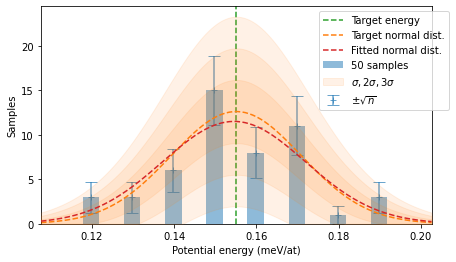

In [ ]:
print(CliRunner().invoke(plot_stats, "--help").output)
print(CliRunner().invoke(plot_stats, 
                   "-n " 
                   "-w 7 -h 4 "
                   "example/VASP_3C-SiC_calculated/2x2x2/T_1200K/DFSET.dat "
                   "1200").output)

## Command line phonon monitoring

This simple command line interface to the phonon plotting function allows for quick monitoring of the phonon calculation. If the sixelplot package is installed it is even possible to plot hi-res plots in the remote terminal supporting sixel standard (e.g. mlterm, xterm on Linux, iterm2 on OSX).

In [ ]:
# hide
# exporti
@click.command()
@click.argument('bands', type=click.Path(exists=True), nargs=-1)
@click.option('-s', '--sixel', is_flag=True, help='Use SixEl driver for terminal graphics.')
@click.option('-n', '--nodecor', is_flag=True, help='Decorate the plot.')
@click.option('-w', '--width', type=float, default=6, help='Width of the figure.')
@click.option('-h', '--height', type=float, default=4, help='Height of the figure.')
@click.option('-o', '--output', type=click.Path(), default="", 
              help='Write output to the file.')
@click.option('-l', '--label', type=str, default="", 
              help='Label(s) for the plot. Comma-separated list')
@click.option('-x', is_flag=True, default=False, 
              help='Make plot in an interactive window')
@click.version_option(hecss.__version__, '-V', '--version',
                      message="HECSS, version %(version)s\n"
                          'High Efficiency Configuration Space Sampler\n'
                          '(C) 2021 by Paweł T. Jochym\n'
                          '    License: GPL v3 or later')
def plot_bands( bands, output, x, sixel, width, height, label, nodecor):
    """
    Plot the phonon dispersion from the file generated by ALAMODE.
    Optionally write out the plot to the output graphics file.
    """
    import hecss.monitor as hm
    import matplotlib.pylab as plt

    
    plt.figure(figsize=(float(width), float(height)))

    ll = label.split(',')
    if len(ll) < len(bands):
        cp = os.path.commonpath(bands)
        rpl = [p[len(cp):][::-1] for p in bands]
        cs = os.path.commonpath(rpl)
        ll = [p[len(cp):-len(cs)] for p in bands]

    for b, l in zip(bands, ll):
        p = Path(b)

        hm.plot_bands_file(p, lbl=l, decorate=not nodecor)

    if label or len(bands)>1:
        plt.legend()

    if output:
        plt.savefig(output)
    if sixel:
        try :
            import sixelplot
        except ImportError:
            print('SixEl graphics support not installed. Install sixelplot package.')
            return
        sixelplot.show()

Usage: plot-bands [OPTIONS] [BANDS]...

  Plot the phonon dispersion from the file generated by ALAMODE. Optionally
  write out the plot to the output graphics file.

Options:
  -s, --sixel         Use SixEl driver for terminal graphics.
  -n, --nodecor       Decorate the plot.
  -w, --width FLOAT   Width of the figure.
  -h, --height FLOAT  Height of the figure.
  -o, --output PATH   Write output to the file.
  -l, --label TEXT    Label(s) for the plot. Comma-separated list
  -x                  Make plot in an interactive window
  -V, --version       Show the version and exit.
  --help              Show this message and exit.




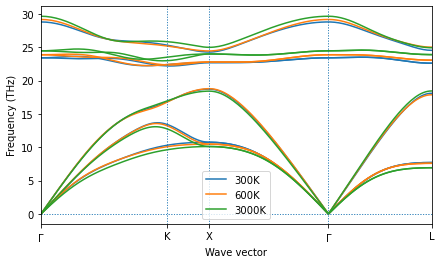

In [ ]:
print(CliRunner().invoke(plot_bands, "--help").output)
print(CliRunner().invoke(plot_bands, 
                   "-w 7 -h 4 -l '300K,600K,3000K' "
                   "example/VASP_3C-SiC_calculated/2x2x2/T_300K/phon/cryst.bands "
                   "example/VASP_3C-SiC_calculated/2x2x2/T_600K/phon/cryst.bands "
                   "example/VASP_3C-SiC_calculated/2x2x2/T_3000K/phon/cryst.bands ").output)